### **Sentiment Analysis - Climate change tweet classification**

imports

In [ ]:
import pandas as pd 
import string
import re
import spacy
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE 
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score, classification_report, confusion_matrix

In [ ]:
#Download Spacy dictionary
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 4.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=e7c7ef87ab8b78227c4ce5b45acf6066d7d4d95922ddeaed1357fe3d60ade83a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfpew0lp/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
#Load spacy dictionary 
nlp = spacy.load('en_core_web_lg')

In [ ]:
#Load CSV files
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv
Saving sample_submission.csv to sample_submission.csv


Load dataset 

In [ ]:
#Load training, testing and sample submission data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [ ]:
#Display first 5 rows of data 
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [ ]:
#get the count of each sentiment in the dataset 
train['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

Text(0, 0.5, 'Frequency')

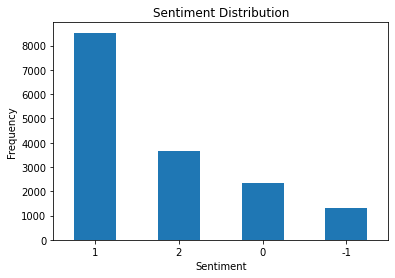

In [ ]:
#Graph of sentiment distribution 
count_sentiment  = pd.value_counts (train['sentiment'], sort = True)
count_sentiment.plot(kind ='bar', rot =0 )
plt.title ('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

Data processing

In [ ]:
#User defined function to remove certain patterns from tweets

def clean_tweet(tweet):
    
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) #remove URLs
    tweet = re.sub('\w*\d\w*', ' ', tweet) # remove numbers
    tweet = tweet.replace('\n', ' ') # remove line breaks
    tweet = re.sub(r'\s\s+', ' ', tweet) #remove white space
    tweet = re.sub('RT[\s]+', '', tweet) # Removing RT
    tweet = re.sub('@[^\s]+','',tweet) #remove @user
    tweet = re.sub("\\W"," ",tweet) #remove special characters

    return tweet

In [ ]:
#Apply the function to the message column of the dataframe
train['message'] = train['message'].apply(clean_tweet)

In [ ]:
#Dataframe after unwanted patterns are removed
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn t think carbon di...,625221
1,1,It s not like we lack evidence of anthropogeni...,126103
2,2,Researchers say we have three years to act on...,698562
3,1,TodayinMaker WIRED was a pivotal year in t...,573736
4,1,It s and a racist sexist climate change d...,466954


In [ ]:
#Creat variable for punctuation
punct = string.punctuation

In [ ]:
#Load stopwords 
stopwords = list(STOP_WORDS)

In [ ]:
#function to tokenize and lemmatize words and also remove, punctuation and capitaliztion
def tweet_tokenizer(tweet):
    
    doc = nlp(tweet)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            word = token.lemma_.lower().strip()
        else:
            word = token.lower_
        
        tokens.append(word)
    
    cleaned_tokens = []
    for token in  tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    
    return cleaned_tokens

Feature Extraction

In [ ]:
#Create variable and assign it to TfidfVectorizer
tfidf  = TfidfVectorizer(tokenizer = tweet_tokenizer)

In [ ]:
#Load which we will use to train the data
model = SVC()


Splitting the data

In [ ]:
#Split data into features and target
X = train['message'] #X is the feature 
y = train['sentiment']#Y is the target variable

In [ ]:
#Vectorize x
X_vectorized = tfidf.fit_transform(X)

In [ ]:
#Split the data into 80:training and 20:testing 
X_train, X_test, y_train, y_test = train_test_split (X_vectorized, y, test_size = 0.2, random_state=42)

In [ ]:
#remove inbalance from the data by using SMOTE
resample_method = SMOTE(kind='borderline1')

In [ ]:
#Fit the SMOTE model to the data 
X_resampled, y_resampled = resample_method.fit_sample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training the model

In [ ]:
#Fit the resampled data to the model we created earlier 
model.fit(X_resampled, y_resampled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Make preadictions using the test data
predicted = model.predict(X_test)

In [ ]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.79      0.32      0.45       278
           0       0.68      0.29      0.40       425
           1       0.71      0.92      0.80      1755
           2       0.80      0.67      0.73       706

    accuracy                           0.73      3164
   macro avg       0.74      0.55      0.60      3164
weighted avg       0.73      0.73      0.70      3164



In [ ]:
print(accuracy_score(y_test, predicted))

0.7266118836915297


In [ ]:
print(f1_score(y_test, predicted))

Testing the model

In [ ]:
#Clean the testing data
test['message'] = test['message'].apply(clean_tweet)

In [ ]:
#Vectorize the testing data
testx = test['message']
test_vect = tfidf.transform(testx)

In [ ]:
#Create submission.csv
y_test = model.predict(test_vect)

result = pd.DataFrame({'tweetid': test.tweetid,
                       'sentiment': y_test})
result.to_csv('submission5.csv', index=False)
result

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0
